In [1]:
# import pandas as pd
# from sklearn.datasets import load_breast_cancer

# # Load the cancer dataset
# cancer = load_breast_cancer()
# df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
# df.columns = df.columns.str.replace(" ", "_")
# df["target"] = cancer.target
# df.to_parquet("cancer.parquet")
# df.head()

import duckdb
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
with duckdb.connect("cancer.db", read_only=False) as con:
    con.execute(
        "CREATE OR REPLACE TABLE cancer AS SELECT * FROM read_parquet('cancer.parquet')"
    )

    df = con.execute("SELECT * FROM cancer").df()


df["cv"] = np.random.randint(0, 6, df.shape[0])
df["cv2"] = np.random.randint(0, 11, df.shape[0])
df["cv3"] = np.random.randint(0, 21, df.shape[0])


pca = PCA(n_components=2)

for col in df.columns.tolist():
    if col not in ["target", "cv", "cv2", "cv3"]:
        df[col] = (df[col] - df[col].mean()) / df[col].std()

X = df.drop(columns=["target", "cv", "cv2", "cv3"])
y = df["target"]
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=["pca1", "pca2"])
df = pd.concat([df, df_pca], axis=1)
df["is_upper_half_of_mean_radius"] = df["mean_radius"] > df["mean_radius"].median()

# make df much larger by resampling 10,000 rows
df = pd.concat([df] * 100, ignore_index=True).drop(columns='cv3')
print(df.shape)
df.head()

(56900, 36)


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv,cv2,pca1,pca2,is_upper_half_of_mean_radius
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,2.107672,2.294058,2.748204,1.935312,0,1,7,9.184755,1.946870,True
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,-0.146620,1.086129,-0.243675,0.280943,0,2,0,2.385703,-3.764859,True
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,0.854222,1.953282,1.151242,0.201214,0,3,7,5.728855,-1.074229,True
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,1.987839,2.173873,6.040726,4.930672,0,1,0,7.116691,10.266556,False
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,0.612640,0.728618,-0.867590,-0.396751,0,5,9,3.931842,-1.946359,True


In [3]:
from glam import DefaultModelData, BinomialGlmAnalysis

dat = DefaultModelData(df, y="target", cv="cv")
dat2 = DefaultModelData(df, y="target", cv="cv2")
print(dat)
dat.df.head()

DefaultModelData(y='target', cv='cv', df.shape=(56900, 36))


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv,cv2,pca1,pca2,is_upper_half_of_mean_radius
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,2.107672,2.294058,2.748204,1.935312,0,1,7,9.184755,1.946870,True
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,-0.146620,1.086129,-0.243675,0.280943,0,2,0,2.385703,-3.764859,True
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,0.854222,1.953282,1.151242,0.201214,0,3,7,5.728855,-1.074229,True
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,1.987839,2.173873,6.040726,4.930672,0,1,0,7.116691,10.266556,False
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,0.612640,0.728618,-0.867590,-0.396751,0,5,9,3.931842,-1.946359,True


In [4]:
glm = BinomialGlmAnalysis(dat)
glm2 = BinomialGlmAnalysis(dat2)

glm.add_feature("mean_radius")
glm2.add_feature("mean_radius")

glm.add_feature("pca1")
glm2.add_feature("pca1")

In [5]:
# %%timeit
glm.fit(parallel=True)

In [6]:
glm.evaluate_new_feature('mean_texture')

,Deviance,DoF,p-value
Model,,,
[Current Model] + mean_texture,13515.78,47696,0.0e+00
mean_radius + pca1,16084.60,47697,


In [13]:
glm.add_feature("mean_texture")
glm.add_feature('compactness_error')
glm.fit()
glm.summary

/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.w

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                47700
Model:                            GLM   Df Residuals:                    47695
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3297.4
Date:                Fri, 23 Aug 2024   Deviance:                       6594.7
Time:                        11:52:44   Pearson chi2:                 5.29e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6943
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6947      0.033     20.887      0.000       0.630       0.760
mean_radius          -2.1499      0.070    -30.681      0.000      -2.287      -2.013
pca1                 -3.1656      0.054    -58.852      0.000      -3.271      -3.060
mean_texture         -1.6618      0.038    -43.793      0.000      -1.736      -1.587
compactness_error     4.6272      0.086     53.512      0.000       4.458       4.797
=====================================================================================
"""

In [14]:
glm.evaluate_new_features(['mean_perimeter',
                           'mean_fractal_dimension',
                           'fractal_dimension_error'])

/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/andy/glam/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.w

Feature evaluation has removed 0 features with p-values greater than 5.0%.


,Deviance,DofF,p_value
Model,,,
[Current Model] + mean_fractal_dimension,5843.89,47694,0.0e+00
[Current Model] + fractal_dimension_error,6402.26,47694,0.0e+00
[Current Model] + mean_perimeter,6498.56,47694,0.0e+00


In [15]:
glm.summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                47700
Model:                            GLM   Df Residuals:                    47695
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3297.4
Date:                Fri, 23 Aug 2024   Deviance:                       6594.7
Time:                        11:54:13   Pearson chi2:                 5.29e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6943
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6947      0.033     20.887      0.000       0.630       0.760
mean_radius          -2.1499      0.070    -30.681      0.000      -2.287      -2.013
pca1                 -3.1656      0.054    -58.852      0.000      -3.271      -3.060
mean_texture         -1.6618      0.038    -43.793      0.000      -1.736      -1.587
compactness_error     4.6272      0.086     53.512      0.000       4.458       4.797
=====================================================================================
"""

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

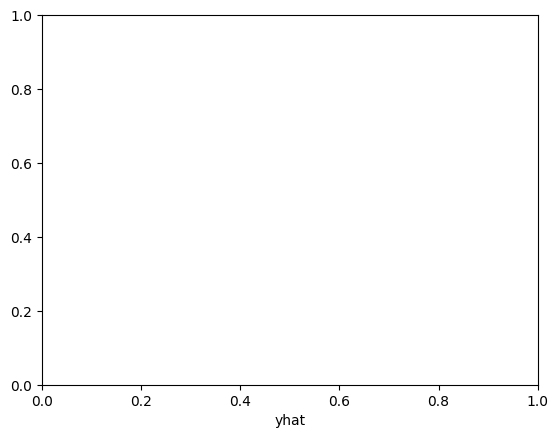

In [31]:
pd.DataFrame({
    'mu':glm.mu.round(6),
    'y':glm.endog,
    'yhat':glm.yhat(),
}).assign(actual_expected=lambda x: f"{x.y} ({x.yhat})").boxplot(column='actual_expected', by='yhat')